# Predicting Student test scores

## Begin by importing relevant packages

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
#XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


In [6]:
#Make sure we are in the right directory
def read_data(test_or_train='train'):
    if 'data' in os.listdir():
        train_df = pd.read_csv(f'data/playground-series-s6e1/{test_or_train}.csv')
    else:
        os.chdir('..')
        train_df = pd.read_csv(f'data/playground-series-s6e1/{test_or_train}.csv')
    return train_df

def create_and_fit_preprocessor(df_train):
    """
    Creates a preprocessor and teaches it (fits it) using the training data.
    Returns the fitted preprocessor.
    """
    # 1. Identify columns
    # Note: We drop target/ID first so we don't accidentally scale them
    X_train = df_train.drop(columns=['id', 'exam_score']) # Assuming 'score' is target
    
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 2. Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            # handle_unknown='ignore' is crucial for test data!
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        verbose_feature_names_out=False # Keeps column names clean
    )

    # 3. FIT the preprocessor on training data
    preprocessor.fit(X_train)
    
    return preprocessor

def process_data(df, preprocessor):
    """
    Uses an EXISTING preprocessor to transform data.
    Does not learn new patterns; simply applies existing rules.
    """
    # Remove ID and Target if they exist (so we only transform features)
    # We use 'errors=ignore' so this works on test data (which might not have a score column)
    X = df.drop(columns=['id', 'score'], errors='ignore')
    
    # 4. TRANSFORM only (do not fit!)
    X_processed = preprocessor.transform(X)
    
    # Optional: Convert back to DataFrame for readability (preserves column names)
    # This requires scikit-learn v1.0+
    try:
        feature_names = preprocessor.get_feature_names_out()
        return pd.DataFrame(X_processed, columns=feature_names)
    except:
        return pd.DataFrame(X_processed)
#Load the dataset
train_df = read_data('train')
test_df = read_data('test')
#Create and fit the preprocessor
preprocessor = create_and_fit_preprocessor(train_df)
#Process the training and test data
X_train_processed = process_data(train_df, preprocessor)
Y_train = train_df['exam_score']
X_test_processed = process_data(test_df, preprocessor)
print(X_train_processed.head())






        age  study_hours  class_attendance  sleep_hours  gender_female  \
0  0.200943     1.655875          1.538302    -1.245269            1.0   
1 -1.126352     0.401573          1.308814    -1.359895            0.0   
2 -0.241488     0.287160          1.182595    -0.729454            1.0   
3 -0.683920    -0.848492         -1.290141     0.703367            0.0   
4  1.085807     1.545699          0.855575     1.448434            0.0   

   gender_male  gender_other  course_b.com  course_b.sc  course_b.tech  ...  \
0          0.0           0.0           0.0          1.0            0.0  ...   
1          0.0           1.0           0.0          0.0            0.0  ...   
2          0.0           0.0           0.0          1.0            0.0  ...   
3          1.0           0.0           0.0          1.0            0.0  ...   
4          1.0           0.0           0.0          0.0            0.0  ...   

   study_method_group study  study_method_mixed  study_method_online videos  \
0

## Visualization of the data:

In [7]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing values in each column:\n", missing_values)



Missing values in each column:
 id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64


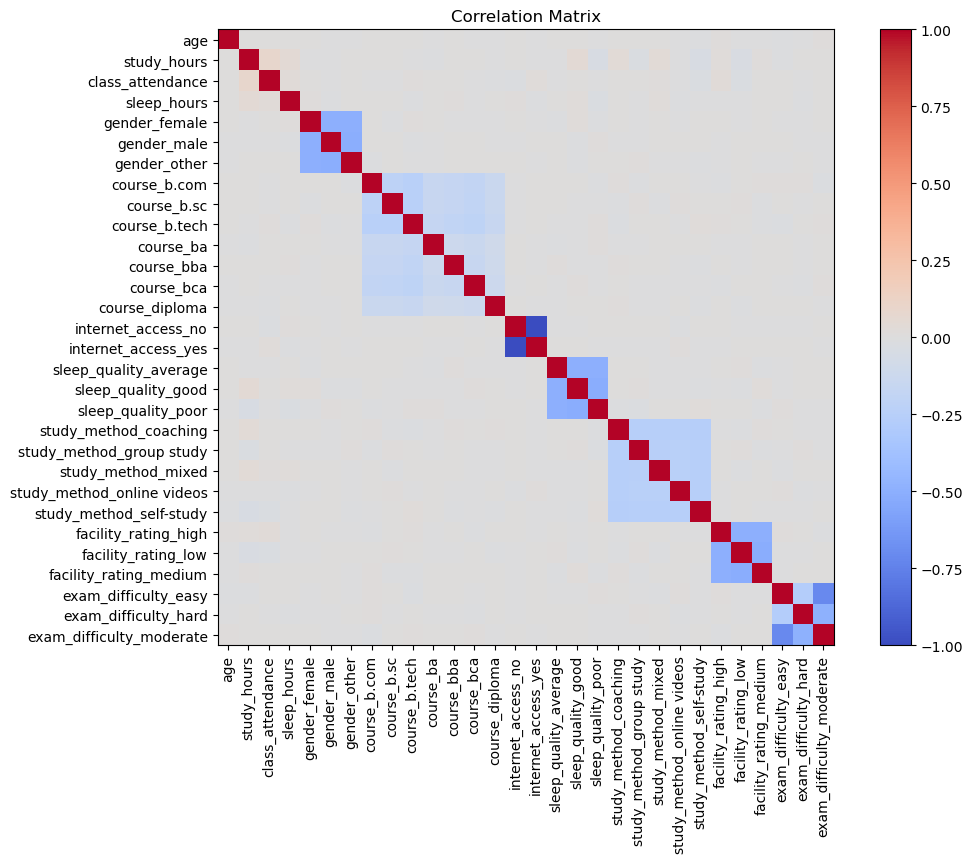

In [8]:
# Check correlations
correlation_matrix = X_train_processed.corr()
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

### Build a RFR usign k-fold validation to find optimal parameters:

In [9]:
# # import Random Forest Regressor and train a model
# from sklearn.ensemble import RandomForestRegressor
# #K-fold cross validation
# from sklearn.model_selection import KFold, cross_val_score
# #import tqdm for progress bar
# from tqdm import tqdm
# #Define features and target variable

# X = train_df.drop(columns=['id', 'exam_score'])
# y = train_df['exam_score']
# #Initialize the model
# n_estimators = [50, 100, 150, 200]
# for n in tqdm(n_estimators):
#     model = RandomForestRegressor(n_estimators=n, random_state=42)
#     #K-fold cross validation
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     #Evaluate the model using cross-validation
#     scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
#     rmse_scores = np.sqrt(-scores)
#     print(f'Random Forest Regressor with {n} estimators - RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std():.2f})')
    


In [10]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold

def tune_xgboost(X_train, y_train, n_iter=50, n_folds=5):
    """
    Finds the best hyperparameters for XGBoost using Randomized Cross Validation.
    
    Args:
        X_train: Preprocessed training features.
        y_train: Training targets.
        n_iter: Number of parameter settings that are sampled (default 50).
        n_folds: Number of folds for K-Fold CV (default 5).
        
    Returns:
        best_model: The XGBoost model refitted with the best parameters.
        best_params: Dictionary of the best parameters found.
    """
    
    # 1. Define the Hyperparameter Search Space
    # Ranges based on standard best practices for tabular data
    param_grid = {
        # Core Parameters
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # aka 'eta'
        'max_depth': [3, 4, 5, 6, 8, 10],         # Controls model complexity
        
        # Regularization (prevent overfitting)
        'min_child_weight': [1, 3, 5, 7],         # Stop splitting if node is too small
        'gamma': [0, 0.1, 0.2, 0.5],              # Min loss reduction required
        
        # Sampling (add randomness to make it robust)
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],   # % of rows used per tree
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9], # % of columns used per tree
        
        # L1/L2 Regularization (optional but good for noise)
        'reg_alpha': [0, 0.01, 0.1, 1],           # L1 (Lasso)
        'reg_lambda': [1, 1.5, 2, 3]              # L2 (Ridge)
    }

    # 2. Initialize the Base Model
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_jobs=-1,        # Use all CPU cores
        random_state=42
    )

    # 3. Setup Cross-Validation Strategy
    # Shuffle=True is critical to ensure random distribution of data across folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # 4. Setup Randomized Search
    random_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_root_mean_squared_error', # Optimized for RMSE
        cv=kf,
        verbose=1,        # Set to 2 or 3 to see more details during training
        random_state=42,
        n_jobs=1         # Parallel processing
    )

    # 5. Run the Search
    print(f"Fitting {n_iter} candidates using {n_folds}-Fold CV...")
    random_search.fit(X_train, y_train)
    
    print("\n✅ Tuning Complete!")
    print(f"Best RMSE Score: {-random_search.best_score_:.4f}")
    print("Best Parameters:")
    for param, val in random_search.best_params_.items():
        print(f"  - {param}: {val}")

    return random_search.best_estimator_, random_search.best_params_

In [11]:
#Tune XGBoost model
best_model, best_params = tune_xgboost(X_train_processed, Y_train, n_iter=50, n_folds=5)

# Predict on test with best model
test_predictions = best_model.predict(X_test_processed)
print("Test Predictions:\n", test_predictions)

#Create Kaggle submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': test_predictions
})
submission_df.to_csv('xgboost_submission.csv', index=False)

Fitting 50 candidates using 5-Fold CV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Tuning Complete!
Best RMSE Score: 8.7565
Best Parameters:
  - subsample: 0.7
  - reg_lambda: 1.5
  - reg_alpha: 0
  - n_estimators: 1000
  - min_child_weight: 1
  - max_depth: 6
  - learning_rate: 0.05
  - gamma: 0.2
  - colsample_bytree: 0.6
Test Predictions:
 [71.901596 70.58372  88.08768  ... 91.11608  54.602    67.672165]
